In [23]:
from env import host, username, password, get_db_url
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def get_telco_data(use_cache=True):
# filename = 'telco_churn.csv'
    
    if os.path.exists('telco.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('telco.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''   
                    SELECT * 
                        FROM customers
                        JOIN contract_types USING(contract_type_id)
                        JOIN internet_service_types USING(internet_service_type_id)
                        JOIN payment_types USING(payment_type_id)
                    '''
            , get_db_url('telco_churn'))
    
    df.to_csv('telco.csv', index=False)
    
    return df

# Regression: Exploration
## Exercises I - Required
***
Our Telco scenario continues:

As a customer analyst for Telco, you want to know who has spent the most money with the company over their lifetime. You have monthly charges and tenure, so you think you will be able to use those two attributes as features to estimate total charges. You need to do this within an average of $5.00 per customer.

*** 

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

Do your work in a notebook named explore.ipynb. In addition, you should create a file named explore.py that contains the following functions for exploring your variables (features & target).



In [24]:
df = get_telco_data()

Using cached csv


In [25]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    # the initial 80/20 split. the test set constitutes 20% of the original df.
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    
    # the subsequent 70/30 split. For the remaining 80%, .7 goes to train and .3 to validate
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test

def prep_telco_data(df):
    # Drop duplicate columns
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'], inplace=True)
       
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    df = df.set_index("customer_id")
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)

    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=False)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
               
    
    num_cols = ['monthly_charges', 'total_charges']

    
        # Selective dummy removal since drop_first left unwanted cols and removed favored
    # kept it mostly random as far as selection of what to drop goes. Purposefully
    # excluded no internet service when optional. 
    df = df.drop(columns=['contract_type_One year', 'device_protection_No internet service',
                          'internet_service_type_DSL',
                          'multiple_lines_No phone service','online_backup_No internet service',
                          'online_security_No internet service', 'payment_type_Mailed check',
                          'streaming_movies_No internet service', 'streaming_tv_No internet service',
                          'tech_support_No internet service'
                         ]
                )
                   
    df = df.rename(columns={'internet_service_type_DSL': 'dsl',
                                   'internet_service_type_Fiber optic': 'fiber_optic',
                                   'internet_service_type_None': 'no_internet',
                                   'contract_type_Month-to-month': 'monthly',
                                   'contract_type_Two year': 'two_year_contract',
                                   'payment_type_Bank transfer (automatic)': 'auto_bank_transfer',
                                   'payment_type_Credit card (automatic)': 'auto_credit_card',
                                   'payment_type_Electronic check': 'electronic_check'
                            }
                   )
    
    
    # split the data
    train, validate, test = split_telco_data(df)
    
    return train, validate, test


1. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [26]:
train, validate, test = prep_telco_data(df)

In [27]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No,streaming_movies_Yes,monthly,two_year_contract,fiber_optic,no_internet,auto_bank_transfer,auto_credit_card,electronic_check
customer_id,,,,,,,,,,,,,,,,,,,,,
2842-JTCCU,Male,0,No,No,2,Yes,No,No,No,No,...,0,1,0,1,0,0,0,1,0,0
2952-QAYZF,Male,0,No,No,5,Yes,Yes,No,Yes,Yes,...,0,1,0,1,0,1,0,0,0,1
1548-FEHVL,Male,0,Yes,No,61,Yes,Yes,Yes,Yes,No,...,1,0,1,1,0,1,0,0,0,1
8782-NUUOL,Male,0,No,No,60,Yes,No,Yes,No,Yes,...,1,0,1,0,0,0,0,0,0,0
5022-JNQEQ,Female,0,Yes,Yes,9,Yes,No,No,No,No,...,0,1,0,1,0,1,0,0,0,1


In [28]:
train.dtypes

gender                        object
senior_citizen                 int64
partner                       object
dependents                    object
tenure                         int64
phone_service                 object
multiple_lines                object
online_security               object
online_backup                 object
device_protection             object
tech_support                  object
streaming_tv                  object
streaming_movies              object
paperless_billing             object
monthly_charges              float64
total_charges                float64
churn                         object
contract_type                 object
internet_service_type         object
payment_type                  object
gender_encoded                 int64
partner_encoded                int64
dependents_encoded             int64
phone_service_encoded          int64
paperless_billing_encoded      int64
churn_encoded                  int64
multiple_lines_No              uint8
m

In [29]:
x = train['tenure']
y = train['total_charges']

x2 = train.tenure
y2 = train.total_charges



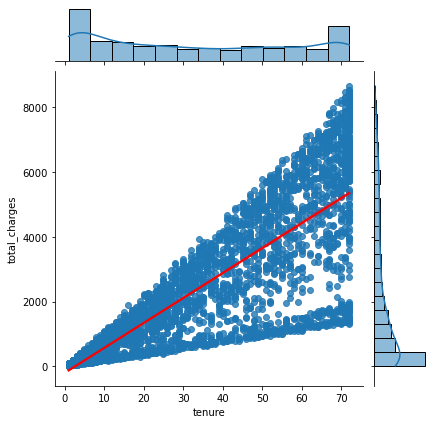

In [37]:
sns.jointplot(x="tenure", y="total_charges", data=train, kind='reg', line_kws={'color': 'red'})
plt.show()

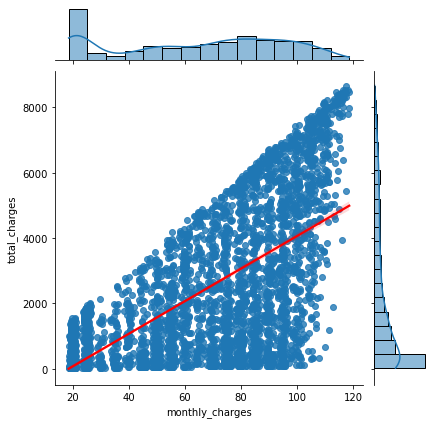

In [39]:
sns.jointplot(x="monthly_charges", y="total_charges", data=train, kind='reg', line_kws={'color': 'red'})
plt.show()

2. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [ ]:
def plot_variable_pairs(df):
    sns.pairplot(df, corner = True, kind = 'reg', plot_kws={'line_kws':{'color':'red'}})

def plot_variable_pairs(df):
    '''accepts a dataframe as input
    split into train, validate, and test
    plots all of the pairwise relationships along with the regression line for each pair.'''
    plot = sns.PairGrid(df)
    plot.map(sns.regplot)
    return plt.show()

In [ ]:
plot_variable_pairs(train)
# well, it's not plotting. After ten minutes.

3. Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.

In [ ]:
def months_to_years(df):
    df['tenure_years'] = (df.tenure / 12).astype(int)
    return df

4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [ ]:
df plot_categorical_and_continuous_vars

5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

6. Explore your dataset with any other visualizations you think will be helpful.

7. In a seperate notebook, use the functions you have developed in this exercise with the mall_customers dataset in the Codeup database server. You will need to write a sql query to acquire your data. Make spending_score your target variable.